# DCT-Based Image Watermarking
    This notebook demonstrates how to apply Discrete Cosine Transform (DCT) for image watermarking and analyzes image quality using various metrics.

## 1. Import Libraries and Load Image
This section:

- Imports necessary libraries for image processing, plotting, and quality metrics
- Loads the input image (`professional.jpg`)
- Converts the image to both RGB and grayscale formats
- Displays the original and grayscale images side by side

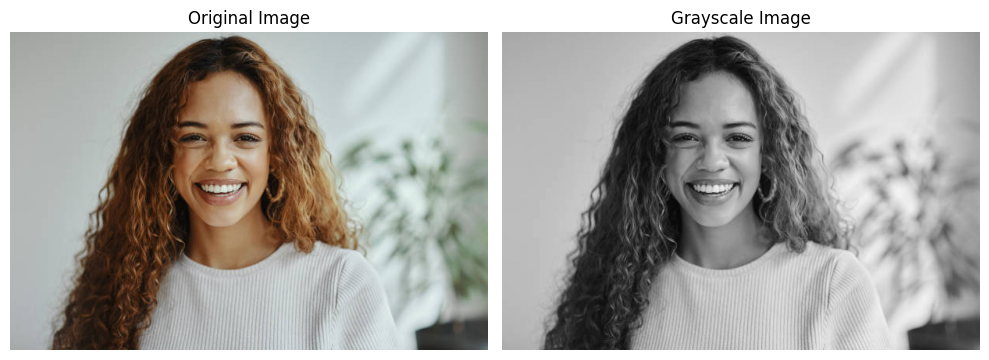

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import hashlib
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

image_path = "professional.jpg"
original_img = cv2.imread(image_path) 
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
gray_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if gray_img is None:
    raise "Image not found or unreadable. Check the path."

plt.figure(figsize = (10,5))
plt.subplot(1, 2, 1)
plt.imshow(original_img_rgb, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.tight_layout()
plt.show()

## 2. Manual 2D DCT and Watermark Embedding
In this section, we:

- Implement a custom 2D DCT function using matrix multiplication
- Convert a text watermark ("V7Shinobi") into binary
- Embed the binary watermark into DCT coefficients
- Apply inverse DCT to reconstruct the watermarked image
- Save and visualize the watermarked result
- Compute PSNR and SSIM between the original and watermarked images to evaluate imperceptibility

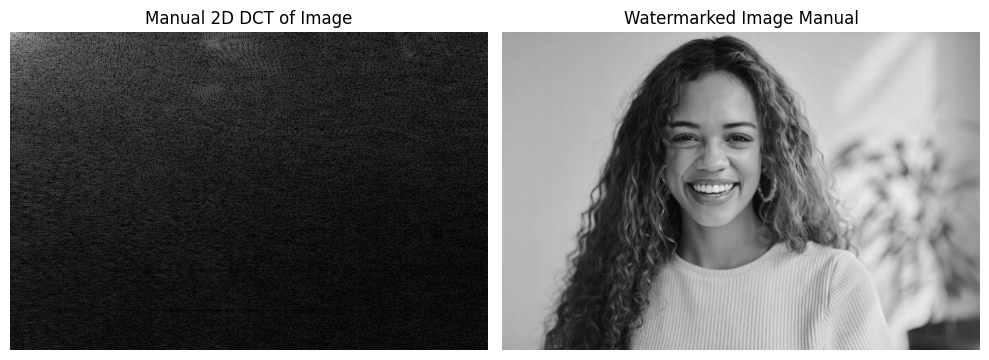

,Metric,Value
0,PSNR,25.326365
1,SSIM,0.962162


In [2]:
def dct_2d(image):
    image = np.array(image, dtype=np.float32)
    M, N = image.shape

    def create_dct_matrix(n):
        dct = np.zeros((n, n))
        for k in range(n):
            for i in range(n):
                if k == 0:
                    dct[k, i] = 1 / np.sqrt(n)
                else:
                    dct[k, i] = np.sqrt(2 / n) * np.cos((np.pi * (2 * i + 1) * k) / (2 * n))
        return dct
    C_M = create_dct_matrix(M)
    C_N = create_dct_matrix(N)
    dct_result = C_M @ image @ C_N.T
    return dct_result

dct_img2 = dct_2d(gray_img)

flat_dct_manual = dct_img2.flatten()
watermark_bin_manual = ''.join(format(ord(char), '08b') for char in "V7Shinobi")
for i,bit in enumerate(watermark_bin_manual):
    flat_dct_manual[i] = flat_dct_manual[i]+1 if bit == '1' else flat_dct_manual[i]-1
watermarked_dct_manual = flat_dct_manual.reshape(dct_img2.shape)
watermarked_img_manual = cv2.idct(watermarked_dct_manual)
watermarked_img_manual = np.clip(watermarked_img_manual, 0, 255).astype(np.uint8)
cv2.imwrite("watermarked_manual.jpg",watermarked_img_manual)
watermark_manual = cv2.imread("watermarked_manual.jpg")

if original_img_rgb.shape != watermark_manual.shape:
    print("Images must have the same dimensions for PSNR/SSIM.")
    

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.log(np.abs(dct_img2) + 1), cmap='gray')
plt.title("Manual 2D DCT of Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(watermark_manual, cmap='gray')
plt.title("Watermarked Image Manual")
plt.axis('off')

plt.tight_layout()
plt.show()

psnr_value_manual = psnr(original_img_rgb, watermark_manual)
ssim_value_manual = ssim(original_img_rgb, watermark_manual, channel_axis=-1)

metrics_manual = {
    "Metric": ["PSNR", "SSIM"],
    "Value": [psnr_value_manual, ssim_value_manual]
}

df = pd.DataFrame(metrics_manual)
df

## 3. Watermark Embedding using OpenCV DCT
This section:

- Applies OpenCV's built-in `cv2.dct()` function to compute the DCT of the grayscale image
- Converts the watermark string ("V7Shinobi") into a binary representation
- Embeds the binary watermark into the DCT coefficients by slightly altering them
- Applies inverse DCT to reconstruct the watermarked image
- Saves and displays the DCT and watermarked images
- Calculates and displays PSNR and SSIM values to assess image quality degradation

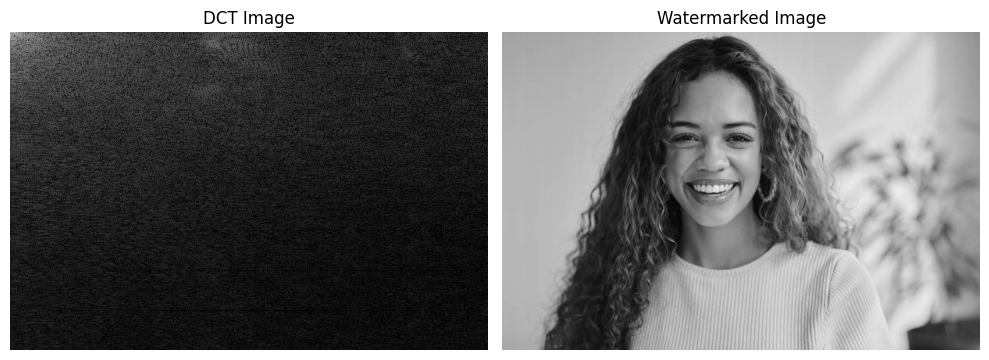

,Metric,Value
0,PSNR,25.326424
1,SSIM,0.962166


In [3]:
dct_img = cv2.dct(np.float32(gray_img))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
dct_vis = np.log(np.abs(dct_img) + 1)
plt.imshow(dct_vis, cmap='gray')
plt.title("DCT Image")
plt.axis('off')
flat_dct = dct_img.flatten()
watermark_bin = ''.join(format(ord(char), '08b') for char in "V7Shinobi")
for i,bit in enumerate(watermark_bin):
    flat_dct[i] = flat_dct[i]+1 if bit == '1' else flat_dct[i]-1
watermarked_dct = flat_dct.reshape(dct_img.shape)
watermarked_img = cv2.idct(watermarked_dct)
watermarked_img = np.clip(watermarked_img, 0, 255).astype(np.uint8)
cv2.imwrite("watermarked.jpg",watermarked_img)
watermark = cv2.imread("watermarked.jpg")

if original_img_rgb.shape != watermark.shape:
    print("Images must have the same dimensions for PSNR/SSIM.")
    

plt.subplot(1, 2, 2)
dct_vis = np.log(np.abs(dct_img) + 1)
plt.imshow(watermark, cmap='gray')
plt.title("Watermarked Image")
plt.axis('off')
plt.tight_layout()
plt.show()

psnr_value = psnr(original_img_rgb, watermark)
ssim_value = ssim(original_img_rgb, watermark, channel_axis=-1)

metrics = {
    "Metric": ["PSNR", "SSIM"],
    "Value": [psnr_value, ssim_value]
}

df = pd.DataFrame(metrics)
df

## 4. Visual Comparison and Metric Evaluation
In this final section:

- We display the original grayscale image, the watermarked image using OpenCV DCT, and the one using the manual DCT
- Compute the Mean Squared Error (MSE) between the original and both watermarked images
- Combine PSNR, SSIM, and MSE values for both methods into a single summary table for comparison

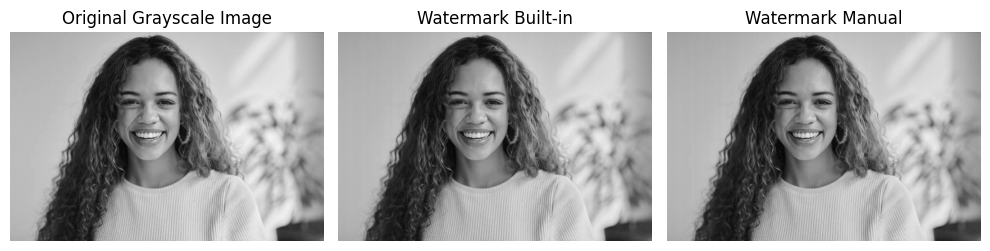

,Metric,Value
0,PSNR Built-in,25.326424
1,PSNR Manual,25.326365
2,SSIM Built-in,0.962166
3,SSIM Manual,0.962162
4,MSE Built-in,43.899435
5,MSE Manual,43.902327


In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(gray_img, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(watermark, cmap='gray')
plt.title("Watermark Built-in")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(watermark_manual, cmap='gray')
plt.title("Watermark Manual")
plt.axis('off')

plt.tight_layout()
plt.show()

mse = np.mean((original_img_rgb - watermark) ** 2)

mse_manual = np.mean((original_img_rgb - watermark_manual) ** 2)

Final = {
    "Metric": ["PSNR Built-in", "PSNR Manual", "SSIM Built-in", "SSIM Manual", "MSE Built-in", "MSE Manual"],
    "Value": [psnr_value, psnr_value_manual, ssim_value, ssim_value_manual, mse, mse_manual]
}

df = pd.DataFrame(Final)
df_transposed = df.set_index("Metric").T
df

## 5. Visualize Pixel Differences
This section visualizes the absolute pixel-wise differences between:

- Original vs. Original (baseline zero-difference)
- Original vs. Built-in Watermarked Image
- Original vs. Manually Watermarked Image

These visualizations help assess how much the watermark alters the image content.

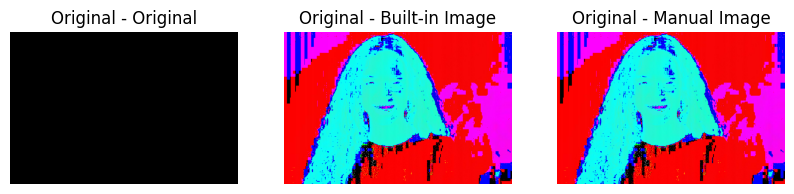

In [5]:
import matplotlib.pyplot as plt
import numpy as np

difference_image_original = np.abs(original_img_rgb - original_img_rgb)
difference_image_manual = np.abs(original_img_rgb - watermark_manual)
difference_image_builtin = np.abs(original_img_rgb - watermark)

# Display the difference image
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(difference_image_original)
plt.title("Original - Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(difference_image_builtin)
plt.title("Original - Built-in Image")
plt.axis('off')
# plt.show()

plt.subplot(1,3,3)
plt.imshow(difference_image_manual, cmap='gray')
plt.title("Original - Manual Image")
plt.axis('off')
plt.show()



## 📌 Conclusion

### Summary of Observations:

In this project, we implemented and analyzed watermarking using the **Discrete Cosine Transform (DCT)** domain, embedding a watermark into an image and assessing the effects.

#### Key Observations:
- **Visual Output**: The watermark was embedded successfully, with only subtle visual differences between the original and watermarked images.
- **Image Quality Metrics**:
  - The **MSE** values quantified the average distortion introduced by watermarking.
  - **PSNR** values indicated that the watermarked images retained good visual quality.
  - **SSIM** scores were close to 1, confirming high structural similarity and preserving perceptual quality.
- **Watermark Impact**: Difference images highlighted the watermark influence concentrated mainly in the frequency domain with minimal spatial degradation.

### What Went Well:
- Demonstrated watermark embedding in the DCT domain effectively.
- Provided clear visual comparisons and difference maps to illustrate watermark impact.
- Used multiple quantitative metrics (**MSE, PSNR, SSIM**) to comprehensively evaluate watermark quality.
- Maintained good balance between watermark visibility and image fidelity.

### What Could Be Improved:
- **Watermark Extraction & Robustness**: The workflow can be extended by implementing watermark extraction and testing robustness against attacks (compression, noise, cropping).
- **Adaptive Embedding Strength**: Dynamically adjusting embedding strength could optimize between invisibility and robustness.
- **Color Image Support**: Extending the method from grayscale to color images would broaden applicability.
- **More Advanced Watermarks**: Experimenting with more complex or multiple watermark patterns for enhanced security.
- **Performance Optimization**: Using faster DCT implementations or block-based processing for large images.

---

This notebook clearly demonstrates watermarking fundamentals in the DCT domain with effective visual and quantitative validation, laying a solid foundation for more advanced watermarking systems.
